# decoupleR (scRNA-seq based)
[decoupleR](https://doi.org/10.1093/bioadv/vbac016) [1] is a package containing different statistical methods to extract biological activities from omics data within a unified framework, including pathway activity inference and transcription factor activity inference. We follow [the instruction](https://decoupler-py.readthedocs.io/en/latest/installation.html) to install decoupler. In [this notebook](https://decoupler-py.readthedocs.io/en/latest/notebooks/dorothea.html) we show how to use [decoupleR](https://decoupler-py.readthedocs.io/en/latest/) for [TF activity inference](https://decoupler-py.readthedocs.io/en/latest/notebooks/dorothea.html) with only the gene expression matrix. 

[1] Badia-i-Mompel, Pau, et al. "decoupleR: ensemble of computational methods to infer biological activities from omics data." _Bioinformatics Advances_ 2.1 (2022): vbac016.

In [1]:
import decoupler as dc
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
from anndata import AnnData

import warnings
warnings.filterwarnings("ignore")

import session_info
session_info.show()

## Loading the scRNA-seq data
For this tutorial, we will analyze a scRNA-seq data consisting in 3k peripheral blood mononuclear cells (PBMCs) from a Healthy Donor which is freely available from [10x Genomics](https://support.10xgenomics.com/single-cell-gene-expression/datasets/1.1.0/pbmc3k). The following command downloads 24.7 MB of [the processed data](https://scanpy.readthedocs.io/en/stable/tutorials/basics/clustering-2017.html) upon the first call and stores it in `data/pbmc3k_processed.h5ad`.

In [2]:
adata = sc.datasets.pbmc3k_processed()
adata

AnnData object with n_obs × n_vars = 2638 × 1838
    obs: 'n_genes', 'percent_mito', 'n_counts', 'louvain'
    var: 'n_cells'
    uns: 'draw_graph', 'louvain', 'louvain_colors', 'neighbors', 'pca', 'rank_genes_groups'
    obsm: 'X_pca', 'X_tsne', 'X_umap', 'X_draw_graph_fr'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

We can visualize the annotated cell types.

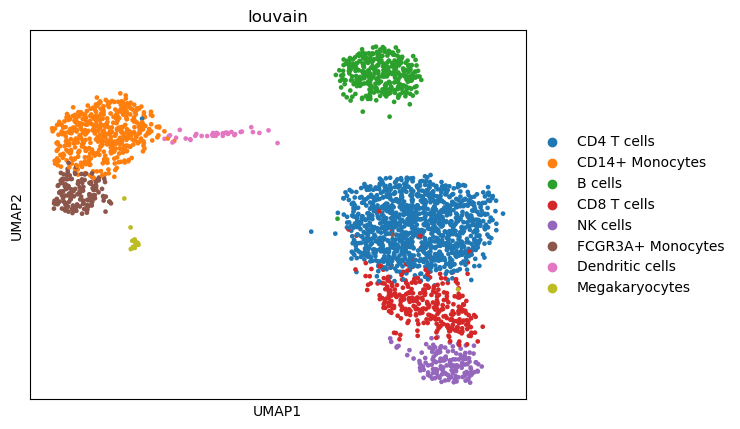

In [3]:
sc.pl.umap(adata, color='louvain')

## Loading the CollecTRI network
[CollecTRI](https://academic.oup.com/nar/article/51/20/10934/7318114) [2] is a comprehensive resource containing a curated collection of TFs and their transcriptional targets compiled from 12 different resources. The interactions are weighted by their mode of regulation (activation or inhibition).

[2] Müller-Dott, Sophia, et al. "Expanding the coverage of regulons from high-confidence prior knowledge for accurate estimation of transcription factor activities." _Nucleic Acids Research_ 51.20 (2023): 10934-10949.

In [ ]:
net = dc.get_collectri(organism='human', split_complexes=False)

In [5]:
net.head()

,source,target,weight,PMID
0,MYC,TERT,1,10022128;10491298;10606235;10637317;10723141;1...
1,SPI1,BGLAP,1,10022617
2,SMAD3,JUN,1,10022869;12374795
3,SMAD4,JUN,1,10022869;12374795
4,STAT5A,IL2,1,10022878;11435608;17182565;17911616;22854263;2...


## Activity inference with univariate linear model (ULM)
For each cell in `adata` and each TF in `net`, decoupleR fits a linear model that predicts the observed gene expression based solely on the TF-target gene interaction weights. Once fitted, the obtained $t$-value of the slope is the score. If it is positive, we interpret that the TF is active and if it is negative we interpret that it is inactive. 

![alt text](https://decoupler-py.readthedocs.io/en/latest/_images/ulm.png)

(Image is linked from [here](https://decoupler-py.readthedocs.io/en/latest/notebooks/dorothea.html).) 

In [6]:
dc.run_ulm(
    mat=adata,
    net=net,
    source='source',
    target='target',
    weight='weight',
    verbose=True)

1 features of mat are empty, they will be removed.
Running ulm on mat with 2638 samples and 13713 targets for 608 sources.


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.27it/s]


The obtained scores `ulm_estimate` and $p$-values `ulm_pvals` are stored in the `.obsm` key.

In [7]:
adata.obsm['ulm_estimate'].head()

,ABL1,AHR,AIRE,AP1,APEX1,AR,ARID1A,ARID1B,ARID3A,ARID3B,...,ZNF362,ZNF382,ZNF384,ZNF395,ZNF436,ZNF699,ZNF76,ZNF804A,ZNF91,ZXDC
AAACATACAACCAC-1,3.105468,0.879592,2.909616,3.406131,0.822555,2.255649,0.622126,-0.454210,-0.497625,-0.454210,...,0.051971,-3.070563,-0.287258,-0.454215,0.485032,-1.168097,0.816615,-0.090827,1.496588,2.328766
AAACATTGAGCTAC-1,0.644366,-0.912154,0.994992,2.265793,0.947906,1.649951,-0.594850,-0.594846,-0.651707,-0.594846,...,-0.334577,0.798243,0.266119,0.217655,-0.651681,-0.263382,1.700061,-0.118951,2.089825,0.693020
AAACATTGATCAGC-1,2.105423,2.411347,2.517772,5.470295,2.126797,3.830123,-0.566923,-0.566920,-0.621111,0.393613,...,-0.841065,-5.552268,0.400809,0.393616,-0.621086,-0.214621,-0.206983,1.408917,1.648628,0.393655
AAACCGTGCTTCCG-1,0.276449,-0.050781,3.699017,3.061379,2.169211,4.214366,-0.523785,-0.523782,-0.573849,-0.523782,...,2.882439,-0.057151,-0.331258,-0.523787,0.356896,0.639145,0.739300,-0.104740,3.708728,2.535483
AAACCGTGTATGCG-1,2.003766,-0.067349,2.869071,3.876005,2.185347,1.854994,-0.393699,1.259139,-0.431328,-0.393696,...,1.182479,0.528313,1.057652,2.912767,-0.431311,2.207839,-0.143738,-0.078726,2.713175,-0.393741


In [8]:
adata.obsm['ulm_pvals'].head()

,ABL1,AHR,AIRE,AP1,APEX1,AR,ARID1A,ARID1B,ARID3A,ARID3B,...,ZNF362,ZNF382,ZNF384,ZNF395,ZNF436,ZNF699,ZNF76,ZNF804A,ZNF91,ZXDC
AAACATACAACCAC-1,0.001904,0.379096,0.003625,6.607955e-04,0.410775,0.024108,0.533869,0.649685,0.618756,0.649685,...,0.958552,2.140735e-03,0.773919,0.649682,0.627661,0.242788,0.414163,0.927631,0.134524,0.019886
AAACATTGAGCTAC-1,0.519349,0.361704,0.319758,2.347956e-02,0.343194,0.098976,0.551954,0.551956,0.514601,0.551956,...,0.737949,4.247433e-01,0.790152,0.827701,0.514618,0.792260,0.089142,0.905316,0.036652,0.488309
AAACATTGATCAGC-1,0.035273,0.015907,0.011821,4.571625e-08,0.033455,0.000129,0.570776,0.570778,0.534537,0.693873,...,0.400326,2.872272e-08,0.688567,0.693871,0.534553,0.830066,0.836026,0.158882,0.099247,0.693842
AAACCGTGCTTCCG-1,0.782207,0.959501,0.000217,2.207465e-03,0.030084,0.000025,0.600437,0.600439,0.566080,0.600439,...,0.003952,9.544259e-01,0.740455,0.600435,0.721175,0.522739,0.459737,0.916584,0.000209,0.011240
AAACCGTGTATGCG-1,0.045115,0.946305,0.004123,1.066800e-04,0.028880,0.063619,0.693809,0.208002,0.666236,0.693811,...,0.237036,5.972906e-01,0.290233,0.003588,0.666249,0.027272,0.885709,0.937251,0.006673,0.693778


## Visualization
Extract the activity matrix from the `adata` object.

In [9]:
adata_tfa = dc.get_acts(adata, obsm_key='ulm_estimate')
adata_tfa

AnnData object with n_obs × n_vars = 2638 × 608
    obs: 'n_genes', 'percent_mito', 'n_counts', 'louvain'
    uns: 'draw_graph', 'louvain', 'louvain_colors', 'neighbors', 'pca', 'rank_genes_groups'
    obsm: 'X_pca', 'X_tsne', 'X_umap', 'X_draw_graph_fr', 'ulm_estimate', 'ulm_pvals'

PAX5 is a master regulator of B cell development. First, we correlate the inferred activity of PAX5 and the mRNA expression of marker genes of B cells.

In [10]:
from scipy.stats import pearsonr
pearsonr(adata.to_df().loc[:, 'CD19'], adata_tfa.to_df().loc[:, 'PAX5'])

PearsonRResult(statistic=0.3181340474526701, pvalue=4.06798308552536e-63)

The inferred TF activity of PAX5 is more informative than the  expression of _PAX5_, since _PAX5_ is expressed only in a few cells.

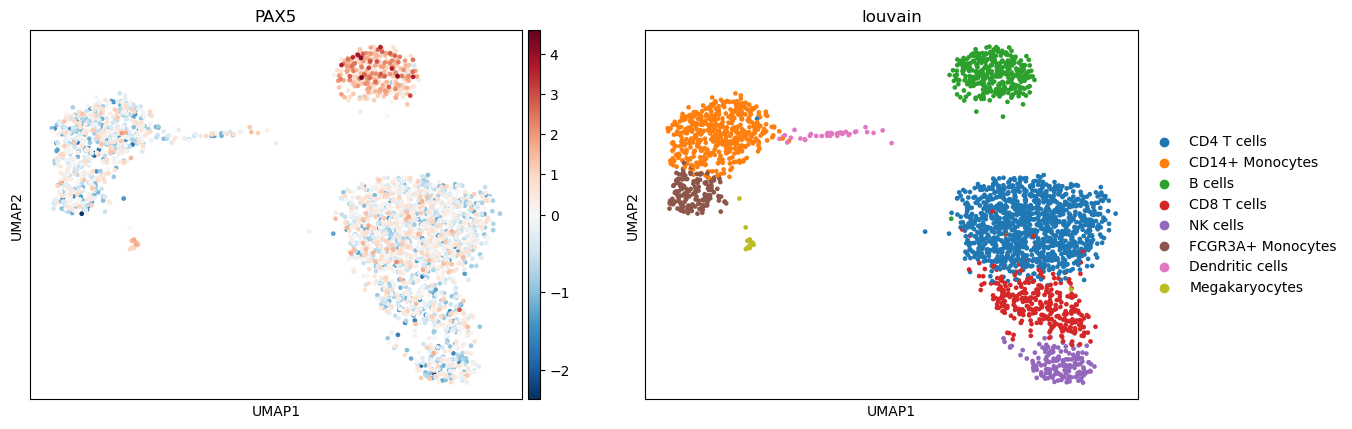

In [11]:
sc.pl.umap(adata_tfa, color=['PAX5', 'louvain'], cmap='RdBu_r', vcenter=0)

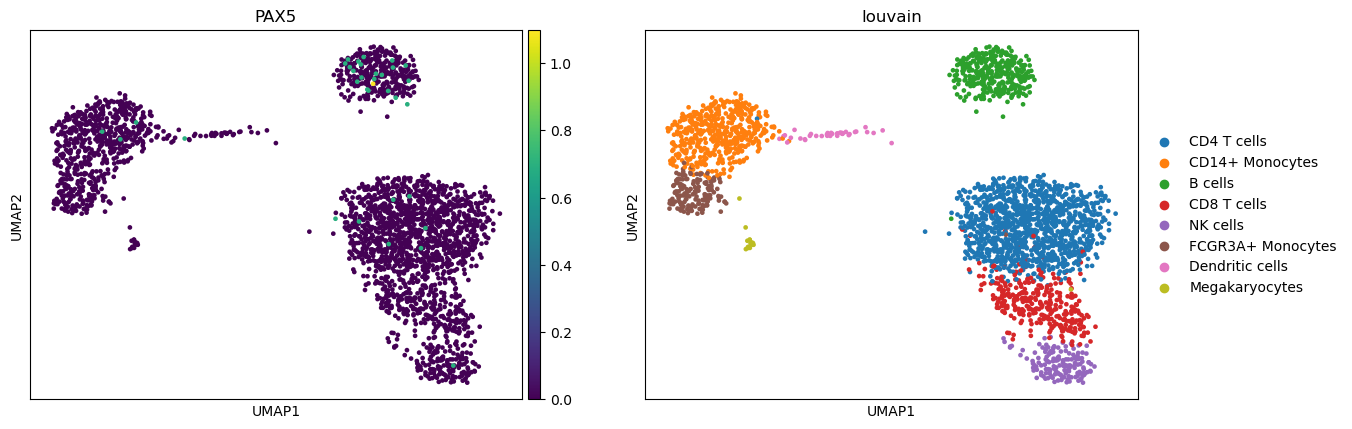

In [12]:
sc.pl.umap(adata, color=['PAX5', 'louvain'])

## Exploration
Now we identify the top TFs by cell type. This can be done by identifying marker TFs statistically.

In [13]:
df = dc.rank_sources_groups(adata_tfa, groupby='louvain', 
                            reference='rest', method='t-test_overestim_var')

In [14]:
df.head()

,group,reference,names,statistic,meanchange,pvals,pvals_adj
0,B cells,rest,EBF1,46.169485,2.599952,7.623835e-180,1.158823e-177
1,B cells,rest,RFXANK,41.651196,10.032308,1.121648e-186,6.819622e-184
2,B cells,rest,RFXAP,41.465581,10.624717,1.993165e-185,4.039481e-183
3,B cells,rest,RFX5,41.407184,8.863535,1.182159e-185,3.593764e-183
4,B cells,rest,CIITA,38.505505,6.445219,7.559347e-173,9.192166e-171


We can then extract the top 3 markers per cell type.

In [15]:
n_markers = 3
source_markers = df.groupby('group').head(n_markers).groupby('group')['names'].apply(lambda x: list(x)).to_dict()

In [16]:
source_markers

{'B cells': ['EBF1', 'RFXANK', 'RFXAP'],
 'CD14+ Monocytes': ['ONECUT1', 'EHF', 'ELF3'],
 'CD4 T cells': ['ZBTB4', 'MYC', 'ZBED1'],
 'CD8 T cells': ['KLF13', 'NFKB2', 'RELB'],
 'Dendritic cells': ['RFXAP', 'RFXANK', 'RFX5'],
 'FCGR3A+ Monocytes': ['SIN3A', 'PPARD', 'SPIC'],
 'Megakaryocytes': ['PKNOX1', 'PBX2', 'FLI1'],
 'NK cells': ['ZGLP1', 'CEBPZ', 'ZNF395']}

We can plot the obtained markers.

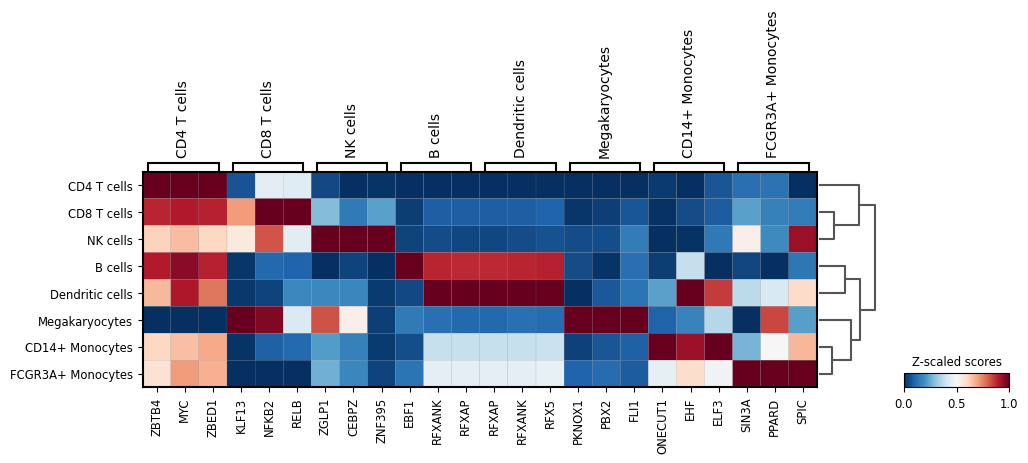

In [17]:
sc.pl.matrixplot(adata_tfa, source_markers, 'louvain', 
                 dendrogram=True, standard_scale='var',
                 colorbar_title='Z-scaled scores', cmap='RdBu_r')

## Saving results to file

In [18]:
!mkdir outputs_decoupler
adata.write('outputs_decoupler/pbmc3k.h5ad')

A subdirectory or file outputs_decoupler already exists.
